In [24]:
#!pip install xgboost
#!pip install category_encoders

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder, OneHotEncoder
from sklearn.feature_selection import (
    SelectKBest, 
    mutual_info_classif, 
    f_regression
)

import xgboost as xgb

import warnings

warnings.filterwarnings('ignore')

In [17]:
column_names = [
    "CRIM",
    "ZN",
    "INDUS",
    "CHAS",
    "NOX",
    "RM",
    "AGE",
    "DIS",
    "RAD",
    "TAX",
    "PTRATIO",
    "B",
    "LSTAT",
    "MEDV"
]


houses = pd.read_csv('housing.csv', header=None, delimiter='\s+', names=column_names)

houses.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [18]:
houses.isna().mean()

CRIM       0.0
ZN         0.0
INDUS      0.0
CHAS       0.0
NOX        0.0
RM         0.0
AGE        0.0
DIS        0.0
RAD        0.0
TAX        0.0
PTRATIO    0.0
B          0.0
LSTAT      0.0
MEDV       0.0
dtype: float64

In [19]:
houses['CHAS'] = houses['CHAS'].map({1:'Yes', 0:'No'})
houses.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,No,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,No,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,No,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,No,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,No,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


# Técnicas interessantes 

- RFE (Recursive Feature Elimination)
- SelectKBest
- SelectFromModel

In [21]:
categorical_columns = houses.select_dtypes(exclude='number').columns.to_list()
numerical_columns = houses.select_dtypes(include='number').columns.to_list()

houses[categorical_columns].head(), houses[numerical_columns].head()

(  CHAS
 0   No
 1   No
 2   No
 3   No
 4   No,
       CRIM    ZN  INDUS    NOX     RM   AGE     DIS  RAD    TAX  PTRATIO  \
 0  0.00632  18.0   2.31  0.538  6.575  65.2  4.0900    1  296.0     15.3   
 1  0.02731   0.0   7.07  0.469  6.421  78.9  4.9671    2  242.0     17.8   
 2  0.02729   0.0   7.07  0.469  7.185  61.1  4.9671    2  242.0     17.8   
 3  0.03237   0.0   2.18  0.458  6.998  45.8  6.0622    3  222.0     18.7   
 4  0.06905   0.0   2.18  0.458  7.147  54.2  6.0622    3  222.0     18.7   
 
         B  LSTAT  MEDV  
 0  396.90   4.98  24.0  
 1  396.90   9.14  21.6  
 2  392.83   4.03  34.7  
 3  394.63   2.94  33.4  
 4  396.90   5.33  36.2  )

In [23]:
# Retiramos o nosso target das variáveis numércias.
numerical_columns = [feature for feature in numerical_columns if feature != 'MEDV']
target = 'MEDV'

In [25]:
X = houses[numerical_columns+categorical_columns]
y = houses[target]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

print(f"""
    X_train: {X_train.shape},
    X_test: {X_test.shape},
    y_train: {y_train.shape},
    y_test: {y_test.shape}
""")


    X_train: (404, 13),
    X_test: (102, 13),
    y_train: (404,),
    y_test: (102,)



In [29]:
xgb_model = xgb.XGBRegressor()

numerical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_columns),
    ('cat', categorical_transformer, categorical_columns)
])

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_selection", SelectKBest(score_func = f_regression, k = 10)),
    ("model", xgb_model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CRIM', 'ZN', 'INDUS', 'NOX',
                                                   'RM', 'AGE', 'DIS', 'RAD',
                                                   'TAX', 'PTRATIO', 'B',
                                                   'LSTAT']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['CHAS'])])),
                ('feature_selection',
                 SelectKBest(score_fun...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"""
    MÉTRICAS DE AVALIAÇÃO:
      
      MAE : {mae:.4f},
      MSE : {mse:.4f},
      RMSE : {rmse:.4f},
      r2 : {r2:.4f}

""")


    MÉTRICAS DE AVALIAÇÃO:
      
      MAE : 1.8237,
      MSE : 5.6503,
      RMSE : 2.3770,
      r2 : 0.9230




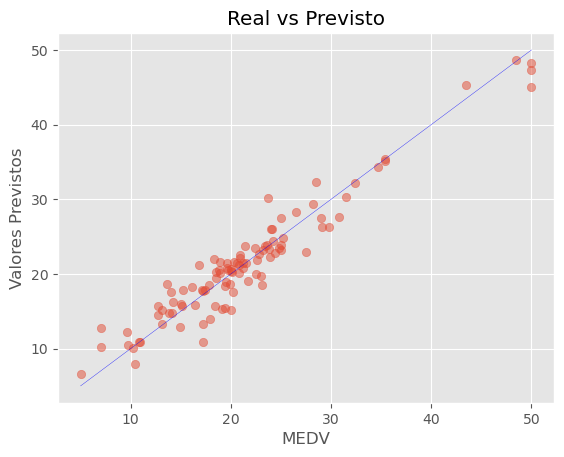

In [45]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')


_ = plt.scatter(y_test, y_pred, alpha=.5)
_ = plt.plot([min(y_test), max(y_test)] , [min(y_test), max(y_test)], 
             linewidth = 0.25, color = 'blue')
_ = plt.xlabel("MEDV")
_ = plt.ylabel("Valores Previstos")
_ = plt.title("Real vs Previsto")
plt.show()